In [1]:
!pip install torch torchvision pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import copy

In [13]:
from google.colab import files
uploaded = files.upload()

Saving 86092.jpg to 86092.jpg
Saving 856047.jpg to 856047.jpg
Saving 863449.jpg to 863449.jpg
Saving 868625.jpg to 868625.jpg
Saving 881100.png to 881100.png
Saving 884203.jpg to 884203.jpg
Saving 884561.jpg to 884561.jpg
Saving 888440.jpg to 888440.jpg
Saving 933391.jpg to 933391.jpg
Saving 972994.jpg to 972994.jpg
Saving 81842.jpg to 81842.jpg
Saving 83995.jpg to 83995.jpg
Saving 85343.jpg to 85343.jpg
Saving 108700.jpg to 108700.jpg
Saving 324310.jpg to 324310.jpg
Saving 422652.jpg to 422652.jpg
Saving 423786.jpg to 423786.jpg
Saving 428771.jpg to 428771.jpg
Saving 436348.jpg to 436348.jpg
Saving 644443.jpg to 644443.jpg
Saving 673478.png to 673478.png
Saving 688916.jpg to 688916.jpg
Saving 733367.png to 733367.png
Saving 753342.jpg to 753342.jpg
Saving 786051.jpg to 786051.jpg
Saving 828002.png to 828002.png
Saving 851497.jpg to 851497.jpg


In [23]:
def image_loader(image_name):
    loader = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(torch.float)

content_img = image_loader("81842.jpg")
style_img = image_loader("851497.jpg")

In [15]:
cnn = models.vgg19(pretrained=True).features.eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.0MB/s]


In [16]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [17]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

In [18]:
def get_style_model_and_losses(cnn, style_img, content_img,
                                content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses

In [19]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, content_img, style_img, input_img,
                       num_steps=300, style_weight=1e6, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img, content_layers, style_layers)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("Step {}: Style Loss : {:4f} Content Loss: {:4f}".format(
                    run[0], style_score.item(), content_score.item()))

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

In [20]:
input_img = content_img.clone()
output = run_style_transfer(cnn, content_img, style_img, input_img)

Building the style transfer model...
Optimizing...
Step 50: Style Loss : 0.000640 Content Loss: 14.080011
Step 100: Style Loss : 0.000140 Content Loss: 16.170490
Step 150: Style Loss : 0.000067 Content Loss: 15.369953
Step 200: Style Loss : 0.000040 Content Loss: 14.854765
Step 250: Style Loss : 0.000022 Content Loss: 13.063791
Step 300: Style Loss : 0.000015 Content Loss: 11.861624


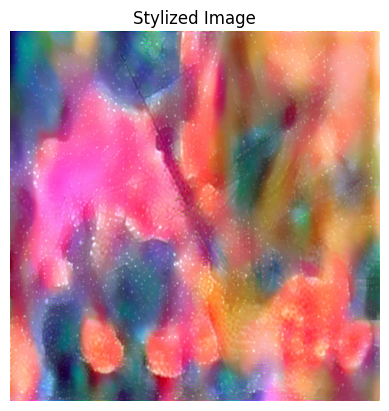

In [24]:
import matplotlib.pyplot as plt
from torchvision import transforms

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

imshow(output, title='Stylized Image')